In [1]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt

import warnings
from scipy import integrate

# $T_q$

In [4]:
#################################### DADOS ###################################

filepath = r"C:\Users\user\Projetos\densities4risk\data\processed\database.parquet"
df = pd.read_parquet(filepath)
TICKER = 'BVSP'
df_bvsp = df[df["ticker"]==TICKER].loc[:,["datetime", "open", "high", "low", "close"]].dropna().drop_duplicates()
df_bvsp.set_index("datetime", inplace=True)

start_time = '10:00'
end_time = '17:00'
freq = '5T'  # 5 minutes

df_bvsp = df[df["ticker"]==TICKER].loc[:,["datetime", "open", "high", "low", "close"]].dropna().drop_duplicates()
df_bvsp.set_index("datetime", inplace=True)

# Create a complete time index for each day
def complete_day(group):
    day = group.index[0].date()
    full_index = pd.date_range(
        f"{day} {start_time}",
        f"{day} {end_time}",
        freq=freq
    )
    return group.reindex(full_index)

# Apply to each day
df_complete = df_bvsp.groupby(df_bvsp.index.date, group_keys=False).apply(complete_day)
# Reset index and rename column
df_complete = df_complete.reset_index().rename(columns={'index': 'datetime'})
df_complete.interpolate(method="linear", inplace=True)

df_complete["R_t"] = df_complete["close"].pct_change()
df_complete["r_t"] = np.log(df_complete["close"]) - np.log(df_complete["close"].shift(1))

C:\Users\user\AppData\Local\Temp\ipykernel_3460\127940432.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(


In [13]:
# example
l_inf = 0
l_sup = 2
n = 512
prob = 0.5

dSup = np.linspace(l_inf, l_sup, n) # support (grid) for Density domain
dens = np.full(n, prob) # density values on dSup - must be strictly positive (otherwise will truncate) and integrate to 1

In [14]:
# Function to convert densities to log quantile density functions

if np.any(dens)<0:
    raise Exception("There are negative density values")
if np.abs(np.trapezoid(dens, dSup) - 1) > 1e-5:
    warnings.warn("Density does not integrate to 1 with tolerance of 1e-5 - renormalizing now.")
    dens = dens/np.trapezoid(dens, dSup)
if np.any(dens==0):  # FUNÇÃO NÃO CONSIDERA POSSIBILIDADE DE ZERO ENTRE LIMITES DE (SUPORTE>O)
    warnings.warn("There are some zero density values - truncating support grid so all are positive.")
    lower_bound = np.min(np.where(dens>0))
    upper_bound = np.max(np.where(dens>0))
    dSup = dSup[lower_bound : upper_bound]
    dens = dens/np.trapezoid(dens, dSup) # ENTENDER POR QUE ISSO FUNCIONA
N = len(dSup)

In [15]:
lqdSup = None #support of length M for lqd domain - must begin at 0 and end at 1; (default: seq(0, 1, length(dSup)))
lqdSup = np.linspace(0,10,11)
lqdSup

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [16]:
SUP = np.array([0,1])

In [17]:
if lqdSup is None:
    lqdSup = np.linspace(0,1,N)
elif not (np.array([lqdSup.min(),lqdSup.max()]) == SUP).all():
    warnings.warn(("Problem with support of the LQD domain's boundaries - resetting to default."))
    lqdSup = np.linspace(0,1,N)

C:\Users\user\AppData\Local\Temp\ipykernel_2916\3479929737.py:4: UserWarning: Problem with support of the LQD domain's boundaries - resetting to default.
  warnings.warn(("Problem with support of the LQD domain's boundaries - resetting to default."))


In [18]:
t0 = dSup[0] # value in dSup for which the cdf value c is retained, i.e. c = F(t0) (default: dSup[0])

In [19]:
if not (t0 in dSup):
    warnings.warn("t0 is not a value in dSup - resetting to closest value")
    t0 = dSup[np.argmin((abs(dSup-t0)))]

In [20]:
M = len(lqdSup)
c_ind = np.where(dSup == t0)[0][0]

In [21]:
# Get CDF and lqd on temporary grid, compute c
tmp = integrate.cumulative_trapezoid(dens, dSup, initial=0)
c = tmp[c_ind]

In [22]:
N_tmp = len(tmp)

# ---- Left duplicates (forward scan)
first_half = tmp[:N_tmp//2]
_, indL = np.unique(first_half, return_index=True)
maskL = np.ones(len(first_half), dtype=bool)
maskL[np.setdiff1d(np.arange(len(first_half)), indL)] = False  # mark duplicates as False

# ---- Right duplicates (reverse scan)
second_half = tmp[N_tmp//2:]
_, indR_rev = np.unique(second_half[::-1], return_index=True)
maskR = np.ones(len(second_half), dtype=bool)
maskR[np.setdiff1d(np.arange(len(second_half)), len(second_half) - 1 - indR_rev)] = False

mask = np.concatenate([maskL, maskR])
qtemp = tmp[mask]

lqd_temp = -np.log(dens[mask])

In [34]:
# Interpolate lqdSup, keeping track of Inf values at boundary, then compute c
lqd = np.full(M, 0)

if np.any(np.isinf([lqd_temp[0], lqd_temp[N-1]])):
    tmpInd = np.arange(1, N)
    Ind = np.arange(1, M)
    if lqd_temp[0] == np.inf:
        lqd[0] = np.inf
        tmpInd = tmpInd[-1]
        Ind = Ind[-1]
    if lqd_temp[-1] == np.inf:
        lqd[M] = np.inf
        tmpInd = tmpInd[-len(tmpInd)]
        Ind = Ind[-len(Ind)]

    interp_values = np.interp(
        lqdSup[Ind-1],                 # xout
        qtemp[tmpInd-1],               # x
        lqd_temp[tmpInd-1],            # y
        left=lqd_temp[tmpInd-1][0],    # rule = 2 → use endpoint values
        right=lqd_temp[tmpInd-1][-1]
    )

    lqd[Ind] = interp_values
else:
    interp_values = np.interp(
        lqdSup,
        qtemp,
        lqd_temp,
        left=lqd_temp[0],    # rule = 2 → use endpoint values
        right=lqd_temp[-1]
    )
    lqd = interp_values

In [27]:
interp_values

array([0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
       0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
       0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
       0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
       0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
       0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
       0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
       0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
       0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
       0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
       0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
       0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
       0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
       0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
       0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314

In [25]:
['lqdSup', lqdSup, 'lqd', lqd, 'c', c]

['lqdSup',
 array([0.        , 0.00195695, 0.00391389, 0.00587084, 0.00782779,
        0.00978474, 0.01174168, 0.01369863, 0.01565558, 0.01761252,
        0.01956947, 0.02152642, 0.02348337, 0.02544031, 0.02739726,
        0.02935421, 0.03131115, 0.0332681 , 0.03522505, 0.037182  ,
        0.03913894, 0.04109589, 0.04305284, 0.04500978, 0.04696673,
        0.04892368, 0.05088063, 0.05283757, 0.05479452, 0.05675147,
        0.05870841, 0.06066536, 0.06262231, 0.06457926, 0.0665362 ,
        0.06849315, 0.0704501 , 0.07240705, 0.07436399, 0.07632094,
        0.07827789, 0.08023483, 0.08219178, 0.08414873, 0.08610568,
        0.08806262, 0.09001957, 0.09197652, 0.09393346, 0.09589041,
        0.09784736, 0.09980431, 0.10176125, 0.1037182 , 0.10567515,
        0.10763209, 0.10958904, 0.11154599, 0.11350294, 0.11545988,
        0.11741683, 0.11937378, 0.12133072, 0.12328767, 0.12524462,
        0.12720157, 0.12915851, 0.13111546, 0.13307241, 0.13502935,
        0.1369863 , 0.13894325, 0.140

In [2]:
# OBS: could not find function "trapzRcpp" -> install.packages("fdapace")

import numpy as np
import warnings
from scipy import integrate

def T_q(
        dens: np.array, 
        dens_support: np.array, 
        lqd_support: np.array = None,
        t0 : int = None
        ) -> list[np.array, np.array, np.float64]:
    """Function for converting densities to log quantile density functions

    Args:
        dens (np.array): density values on dSup - must be strictly positive (otherwise will truncate) and integrate to 1.
        dens_support (np.array): support (grid) for Density domain.
        lqd_support (np.array, optional): support of length M for lqd domain - must begin at 0 and end at 1. Defaults to None.
        t0 (int, optional): value in dSup for which the cdf value c is retained, i.e. c = F(t0). Defaults to None.

    Returns:
    list[np.array, np.array, np.float64]: [lqd_support, lqd, c]
    """
    lqd_support = np.linspace(0,1, len(dens_support))
    t0 = dens_support[0]

    if np.any(dens<0):
        raise Exception("There are negative density values")
    if np.abs(np.trapezoid(dens, dens_support) - 1) > 1e-5:
        warnings.warn("Density does not integrate to 1 with tolerance of 1e-5 - renormalizing now.")
        dens = dens/np.trapezoid(dens, dens_support)
    if np.any(dens==0):  # FUNÇÃO NÃO CONSIDERA POSSIBILIDADE DE ZERO ENTRE LIMITES DE (SUPORTE>O)
        warnings.warn("There are some zero density values - truncating support grid so all are positive.")
        lower_bound = np.min(np.where(dens>0))
        upper_bound = np.max(np.where(dens>0))
        dens_support = dens_support[lower_bound : upper_bound]
        dens = dens/np.trapezoid(dens, dens_support) # ENTENDER POR QUE ISSO FUNCIONA
        
    N = len(dens_support)

    if lqd_support is None:
        lqd_support = np.linspace(0,1,N)
    elif not (np.array([lqd_support.min(),lqd_support.max()]) == np.array([0,1])).all():
        warnings.warn(("Problem with support of the LQD domain's boundaries - resetting to default."))
        lqd_support = np.linspace(0,1,N)
        
    if not (t0 in dens_support):
        warnings.warn("t0 is not a value in dSup - resetting to closest value")
        t0 = dens_support[np.argmin((abs(dens_support-t0)))]
    M = len(lqd_support)
    c_ind = np.where(dens_support == t0)[0][0]

    # Get CDF and lqd on temporary grid, compute c
    tmp = integrate.cumulative_trapezoid(dens, dens_support, initial=0)
    c = tmp[c_ind]

    N_tmp = len(tmp)

    # ---- Left duplicates (forward scan)
    first_half = tmp[:N_tmp//2]
    _, indL = np.unique(first_half, return_index=True)
    maskL = np.ones(len(first_half), dtype=bool)
    maskL[np.setdiff1d(np.arange(len(first_half)), indL)] = False  # mark duplicates as False

    # ---- Right duplicates (reverse scan)
    second_half = tmp[N_tmp//2:]
    _, indR_rev = np.unique(second_half[::-1], return_index=True)
    maskR = np.ones(len(second_half), dtype=bool)
    maskR[np.setdiff1d(np.arange(len(second_half)), len(second_half) - 1 - indR_rev)] = False

    mask = np.concatenate([maskL, maskR])
    qtemp = tmp[mask]

    lqd_temp = -np.log(dens[mask])

    # Interpolate lqd_support, keeping track of Inf values at boundary, then compute c
    lqd = np.full(M, 0)

    if np.any(np.isinf([lqd_temp[0], lqd_temp[N-1]])):
        tmpInd = np.arange(1, N)
        Ind = np.arange(1, M)
        if lqd_temp[0] == np.inf:
            lqd[0] = np.inf
            tmpInd = tmpInd[-1]
            Ind = Ind[-1]
        if lqd_temp[-1] == np.inf:
            lqd[M] = np.inf
            tmpInd = tmpInd[-len(tmpInd)]
            Ind = Ind[-len(Ind)]

        interp_values = np.interp(
            lqd_support[Ind-1],                 # xout
            qtemp[tmpInd-1],               # x
            lqd_temp[tmpInd-1],            # y
            left=lqd_temp[tmpInd-1][0],    # rule = 2 → use endpoint values
            right=lqd_temp[tmpInd-1][-1]
        )

        lqd[Ind] = interp_values
    else:
        interp_values = np.interp(
            lqd_support,
            qtemp,
            lqd_temp,
            left=lqd_temp[0],    # rule = 2 → use endpoint values
            right=lqd_temp[-1]
        )
        lqd = interp_values

    return [lqd_support, lqd, c]

In [125]:
# example
l_inf = 0
l_sup = 2
n = 512
prob = 0.5

dens_support = np.linspace(l_inf, l_sup, n) # support (grid) for Density domain
dens = np.full(n, prob) # density values on dSup - must be strictly positive (otherwise will truncate) and integrate to 1

In [126]:
lqd_support, lqd, c = T_q(dens, dens_support)

In [194]:
import pandas as pd
import json

json_file_path = r"..\data\processed\densities.json"

with open(json_file_path, 'r') as j:
     densities = json.loads(j.read())

In [195]:
dens_support = np.array(densities["1"]["x_grid"])
dens = np.array(densities["1"]["y_kde"])

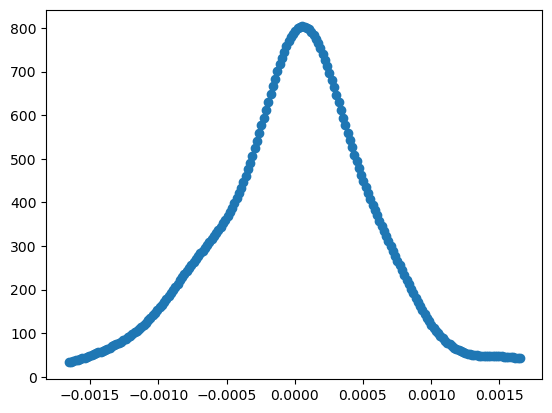

In [196]:
import matplotlib.pyplot as plt

plt.figure()

plt.scatter(dens_support, dens)

plt.show()

In [70]:
lqd_support, lqd, c = T_q(dens, dens_support)

C:\Users\user\AppData\Local\Temp\ipykernel_2916\2534271188.py:30: UserWarning: Density does not integrate to 1 with tolerance of 1e-5 - renormalizing now.
  warnings.warn("Density does not integrate to 1 with tolerance of 1e-5 - renormalizing now.")


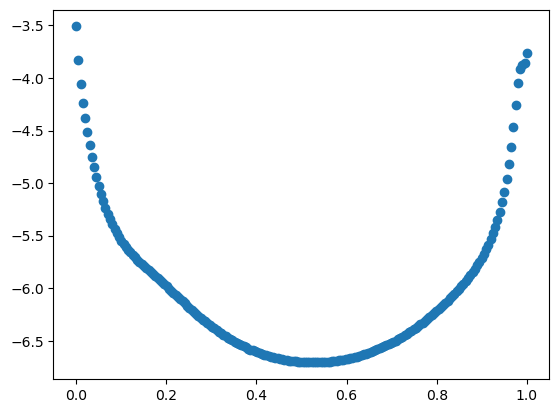

In [72]:
plt.figure()

plt.scatter(lqd_support, lqd)

plt.show()

# $T_{q}^{-1}$

In [147]:
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline
from scipy.integrate import quad

In [233]:
x = np.linspace(0,2,512)
y_lqd = np.full(512, np.log(2))
lqdSup = np.linspace(0,1,len(y_lqd))
cut=[0,0]
t0=0
c=0
useSplines = True

In [107]:
if not (np.array([lqdSup.min(),lqdSup.max()]) == np.array([0,1])).all():
    warnings.warn("Problem with support of the LQD domain's boundaries - resetting to default.")
    lqdSup = np.linspace(0,1,len(lqd))

In [130]:
M = len(y_lqd)
r = np.where(np.exp(lqd)==np.inf)[0]

In [134]:
if len(r)>0:
    if np.any(r < int(M/2)):
        cut[0] = np.max(cut[0], np.max(r[r<int(M/2)]))
    if np.any(r >= int(M/2)):
        cut[1] = np.max(cut[1], M - np.min(r[r >= int(M/2)]))

In [175]:
# Cut boundaries
ldqSup = lqdSup[(cut[0]+1):(M-cut[1])]
lqd    = lqd[(cut[1]+1):(M-cut[1])]
M      = len(y_lqd) # reset N

In [176]:
if not (c in lqdSup):
    if (c < lqdSup[0] or c > lqdSup[M]):
        raise Exception ("c is not contained withing range of lqdSup after cutoff")
    print("c is not equal to a value in lqdSup - resetting to closest value")
    c = lqdSup[np.argmin(abs(lqdSup-c))]

In [177]:
c_ind = np.where(lqdSup==c)[0]

In [178]:
if useSplines:
    # 1. Natural cubic spline equivalent to splinefun(..., method="natural")
    lqd_sp = CubicSpline(lqdSup, y_lqd, bc_type='natural')
    # 2. Define exp(lqd_sp(t))
    def lqd_exp(t):
        return np.exp(lqd_sp(t))
    # 3. Compute the cumulative integrals between successive lqdSup points
    integrals = [quad(lqd_exp, lqdSup[i-1], lqdSup[i])[0] for i in range(1, len(lqdSup))]
    # 4. Construct dtemp (cumulative density grid)
    dtemp = t0 + np.concatenate(([0], np.cumsum(integrals))) - \
                quad(lqd_exp, lqdSup[0], lqdSup[c_ind])[0]
else:
    # Compute cumulative trapezoidal integral
    cum_int = integrate.cumulative_trapezoid(np.exp(y_lqd), lqdSup, initial=0)

    # Compute trapezoidal integral up to c_ind
    trap_int = integrate.trapezoid(np.exp(y_lqd[:c_ind]), lqdSup[:c_ind], initial=0)

    # Build dtemp
    dtemp = t0 + cum_int - trap_int

In [185]:
# Remove Duplicates
# --- Split indices
mid = M // 2

# --- Detect duplicates (left: check from end, right: from start)
_, indL = np.unique(dtemp[:mid][::-1], return_index=True)
indL_mask = np.ones(mid, dtype=bool)
indL_mask[np.setdiff1d(np.arange(mid), mid - 1 - indL)] = False  # equivalent to duplicated(..., fromLast=TRUE)

_, indR = np.unique(dtemp[mid:], return_index=True)
indR_mask = np.ones(M - mid, dtype=bool)
indR_mask[np.setdiff1d(np.arange(M - mid), indR)] = False  # equivalent to duplicated(...)

# --- Combine masks
mask = np.concatenate([indL_mask, indR_mask])

# --- Apply mask
dtemp = dtemp[mask]
dens_temp = np.exp(-y_lqd[mask])

In [187]:
from scipy.interpolate import interp1d
# Interpolate to dSup and normalize
# 1. Build uniform grid
dSup = np.linspace(dtemp[0], dtemp[-1], M)

# 2. Interpolate dens_temp to dSup (constant extrapolation on both sides)
interp_func = interp1d(dtemp, dens_temp, kind='linear',
                       bounds_error=False, fill_value=(dens_temp[0], dens_temp[-1]))
dens = interp_func(dSup)

# 3. Normalize, accounting for boundary cutoff
area = integrate.trapezoid(dens, dSup)
dens = dens / area * (lqdSup[-1] - lqdSup[0])

In [188]:
['dSup', dSup, 'dens', dens]

['dSup',
 array([0.        , 0.00391389, 0.00782779, 0.01174168, 0.01565558,
        0.01956947, 0.02348337, 0.02739726, 0.03131115, 0.03522505,
        0.03913894, 0.04305284, 0.04696673, 0.05088063, 0.05479452,
        0.05870841, 0.06262231, 0.0665362 , 0.0704501 , 0.07436399,
        0.07827789, 0.08219178, 0.08610568, 0.09001957, 0.09393346,
        0.09784736, 0.10176125, 0.10567515, 0.10958904, 0.11350294,
        0.11741683, 0.12133072, 0.12524462, 0.12915851, 0.13307241,
        0.1369863 , 0.1409002 , 0.14481409, 0.14872798, 0.15264188,
        0.15655577, 0.16046967, 0.16438356, 0.16829746, 0.17221135,
        0.17612524, 0.18003914, 0.18395303, 0.18786693, 0.19178082,
        0.19569472, 0.19960861, 0.2035225 , 0.2074364 , 0.21135029,
        0.21526419, 0.21917808, 0.22309198, 0.22700587, 0.23091977,
        0.23483366, 0.23874755, 0.24266145, 0.24657534, 0.25048924,
        0.25440313, 0.25831703, 0.26223092, 0.26614481, 0.27005871,
        0.2739726 , 0.2778865 , 0.28180

In [3]:

from scipy import integrate
from scipy import interpolate

def T_q_inv(
                lqd    : np.array, 
                lqdSup : np.array = None,
                t0 = 0,
                c  = 0,
                useSplines = True,
                cut = [0,0]
        ) -> list[np.array, np.array]:
        """Function for converting log quantile densities to densities.

        Args:
                lqd (np.array): log quantile density on lqdSup
                lqdSup (np.array, optional): support for lqd domain - must begin at 0 and end at 1. Defaults to None.
                t0 (int, optional): value for which the target cdf has F(t0) = c (default: 0). Defaults to 0.
                c (int, optional): value in lqdSup representing the value of target cdf at t0 (default: lqdSup[1]). Defaults to 0.
                useSplines (bool, optional): fit spline to the lqd when doing the numerical integration (default: TRUE). Defaults to True.
                cut (list, optional): vector with two elements, indicating how many boundary to cut on the left and right side (default: c(0, 0)).  More will be cut off if exp(lqd) is infinite for some values.. Defaults to [0,0].

        Returns:
                list[np.array, np.array]: [dSup, dens]
        """
        if not (np.array([lqdSup.min(),lqdSup.max()]) == np.array([0,1])).all():
                warnings.warn("Problem with support of the LQD domain's boundaries - resetting to default.")
                lqdSup = np.linspace(0,1,len(lqd))
        M = len(lqd)
        r = np.where(np.exp(lqd)==np.inf)[0]
        if len(r)>0:
                print(r)
                if np.any(r < int(M/2)):
                        cut[0] = np.max(cut[0], np.max(r[r<int(M/2)]))
                if np.any(r >= int(M/2)):
                        cut[1] = np.max(cut[1], M - np.min(r[r >= int(M/2)]))
        
        # Cut boundaries
        lqdSup = lqdSup[(cut[0]):(M-cut[1])]
        lqd    = lqd[(cut[0]):(M-cut[1])]
        M      = len(lqd) # reset N
        if not (c in lqdSup):
                if (c < lqdSup[0] or c > lqdSup[M]):
                        raise Exception ("c is not contained withing range of lqdSup after cutoff")
                print("c is not equal to a value in lqdSup - resetting to closest value")
                c = lqdSup[np.argmin(abs(lqdSup-c))]
        
        c_ind = np.where(lqdSup==c)[0]

        if useSplines:
                # 1. Natural cubic spline equivalent to splinefun(..., method="natural")
                lqd_sp = interpolate.CubicSpline(lqdSup, lqd, bc_type='natural')
                # 2. Define exp(lqd_sp(t))
                def lqd_exp(t):
                        return np.exp(lqd_sp(t))
                # 3. Compute the cumulative integrals between successive lqdSup points
                integrals = [integrate.quad(lqd_exp, lqdSup[i-1], lqdSup[i])[0] for i in range(1, len(lqdSup))]
                # 4. Construct dtemp (cumulative density grid)
                dtemp = t0 + np.concatenate(([0], np.cumsum(integrals))) - \
                                integrate.quad(lqd_exp, lqdSup[0], lqdSup[c_ind])[0]
        else:
                # Compute cumulative trapezoidal integral
                cum_int = integrate.cumulative_trapezoid(np.exp(lqd), lqdSup, initial=0)

                # Compute trapezoidal integral up to c_ind
                trap_int = integrate.trapezoid(np.exp(lqd[:c_ind]), lqdSup[:c_ind], initial=0)

                # Build dtemp
                dtemp = t0 + cum_int - trap_int
        # Remove Duplicates
        # --- Split indices
        mid = M // 2

        # --- Detect duplicates (left: check from end, right: from start)
        _, indL = np.unique(dtemp[:mid][::-1], return_index=True)
        indL_mask = np.ones(mid, dtype=bool)
        indL_mask[np.setdiff1d(np.arange(mid), mid - 1 - indL)] = False  # equivalent to duplicated(..., fromLast=TRUE)

        _, indR = np.unique(dtemp[mid:], return_index=True)
        indR_mask = np.ones(M - mid, dtype=bool)
        indR_mask[np.setdiff1d(np.arange(M - mid), indR)] = False  # equivalent to duplicated(...)

        # --- Combine masks
        mask = np.concatenate([indL_mask, indR_mask])

        # --- Apply mask
        dtemp = dtemp[mask]
        dens_temp = np.exp(-lqd[mask])

        # Interpolate to dSup and normalize
        # 1. Build uniform grid
        dSup = np.linspace(dtemp[0], dtemp[-1], M)

        # 2. Interpolate dens_temp to dSup (constant extrapolation on both sides)
        interp_func = interpolate.interp1d(dtemp, dens_temp, kind='linear',
                        bounds_error=False, fill_value=(dens_temp[0], dens_temp[-1]))
        dens = interp_func(dSup)

        # 3. Normalize, accounting for boundary cutoff
        area = integrate.trapezoid(dens, dSup)
        dens = dens / area * (lqdSup[-1] - lqdSup[0])

        return [dSup, dens]

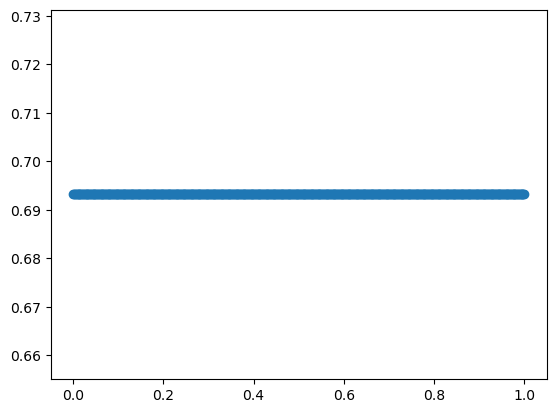

In [232]:
plt.figure()

plt.scatter(lqdSup, y_lqd)

plt.show()

In [235]:
x_grid, dens = T_q_inv(lqd = y_lqd, lqdSup = lqdSup)

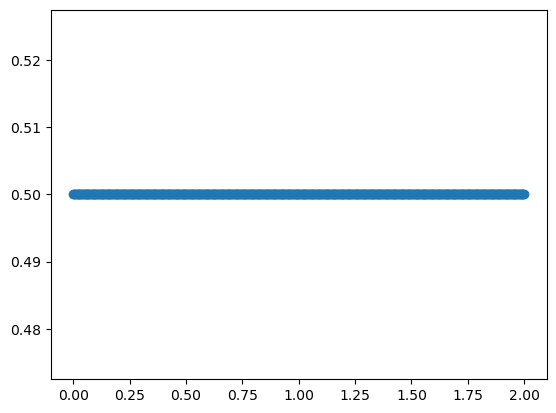

In [236]:
plt.figure()

plt.scatter(x_grid, dens)

plt.show()

# Teste densidade real

In [9]:
json_file_path = r"..\data\processed\densities.json"

with open(json_file_path, 'r') as j:
     densities = json.loads(j.read())

dens_support = np.array(densities["1"]["x_grid"])
dens = np.array(densities["1"]["y_kde"])

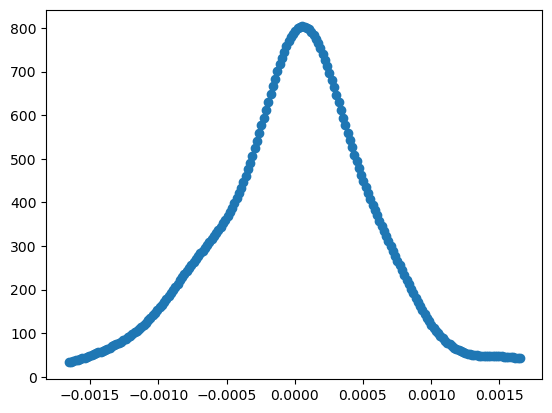

In [10]:
plt.figure()

plt.scatter(dens_support, dens)

plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_16452\2231505827.py:30: UserWarning: Density does not integrate to 1 with tolerance of 1e-5 - renormalizing now.
  warnings.warn("Density does not integrate to 1 with tolerance of 1e-5 - renormalizing now.")


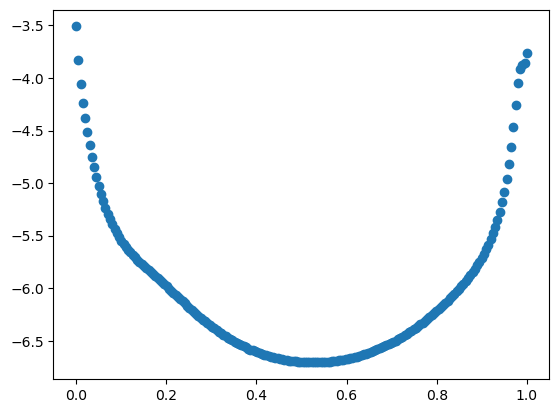

In [11]:
lqd_support, lqd, c = T_q(dens, dens_support)

plt.figure()

plt.scatter(lqd_support, lqd)

plt.show()

In [13]:
dens_support, dens = T_q_inv(lqd = lqd, lqdSup = lqd_support)

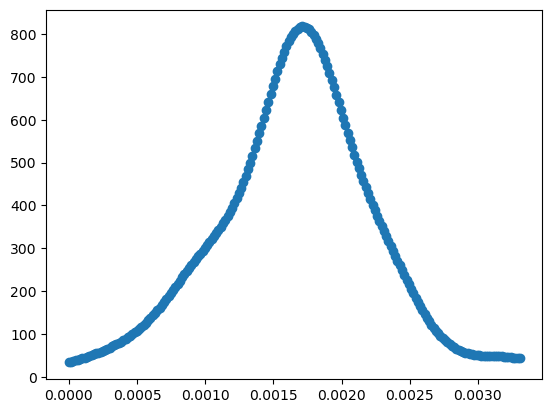

In [14]:
plt.figure()

plt.scatter(dens_support, dens)

plt.show()